![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 4 - Deep Learning Basics</center>
### <center> Regularization Methods (Weight Decay and Dropout) </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/04_Regularizations/MainRegularization.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})
np.random.seed(2)

For Colab users:

In [1]:
if 'google.colab' in str(get_ipython()):
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/04_Regularizations/DeepLearningFramework ./DeepLearningFramework

In [5]:
#-- What we have so far:
from DeepLearningFramework.Layers    import LinearLayer, ReLULayer
from DeepLearningFramework.Models    import SequentialModel
from DeepLearningFramework.Metric    import CrossEntropyLoss, Accuracy
from DeepLearningFramework.Dataset   import Dataset
from DeepLearningFramework.Optimizer import Optimizer, SGDM
from DeepLearningFramework.Training  import Epoch

### Get Cifar-10 dataset

In [6]:
import torchvision
import torchvision.transforms as transforms

#-- For now, we use PyTorch just to get the data:
oTorchTrainSet = torchvision.datasets.CIFAR10(root='../../data', train=True,  download=True, transform=transforms.ToTensor())
# oTorchTestSet  = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

mX       = oTorchTrainSet.data.reshape((-1, 32*32*3)) / 255
vY       = np.array(oTorchTrainSet.targets)
mX.shape, vY.shape

Files already downloaded and verified


((50000, 3072), (50000,))

In [7]:
lClasses = oTorchTrainSet.classes
list(zip(range(10), lClasses))

[(0, 'airplane'),
 (1, 'automobile'),
 (2, 'bird'),
 (3, 'cat'),
 (4, 'deer'),
 (5, 'dog'),
 (6, 'frog'),
 (7, 'horse'),
 (8, 'ship'),
 (9, 'truck')]

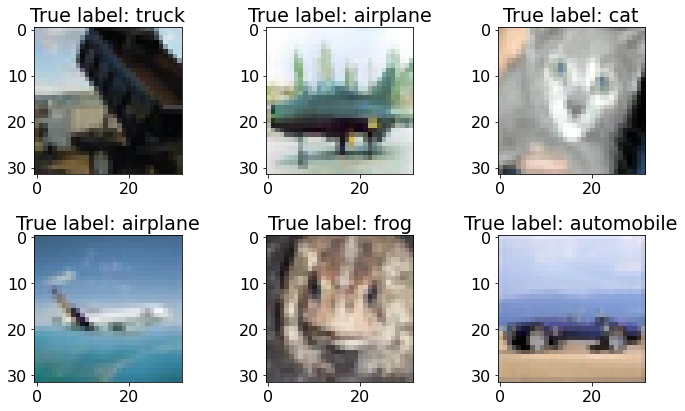

In [8]:
#-- Plot a few examples:
N, d   = mX.shape
fig, _ = plt.subplots(2, 3, figsize=(10,6))
for ax in fig.axes:
    idx = np.random.randint(N)
    ax.imshow   (np.reshape(mX[idx,:], (32, 32, 3)))
    ax.set_title(f'True label: {lClasses[vY[idx]]}')
    
plt.tight_layout()
plt.show()

####  Normalize data:

In [9]:
vMean = np.mean(mX, axis=0)
vStd  = np.std (mX, axis=0)
mX    = (mX - vMean) / vStd

####  Split to train and validation:

In [10]:
from sklearn.model_selection import train_test_split

nTrain = 45000
nVal   = 5000
mTrainX, mValX, vTrainY, vValY = train_test_split(mX, vY, train_size=nTrain, test_size=nVal)

batchSize = 512
oTrainSet = Dataset(mTrainX.T, vTrainY, batchSize)
oValSet   = Dataset(mValX.T,   vValY,   2*batchSize)

len(oTrainSet), len(oValSet)

(88, 5)

####  Define a model:

In [11]:
def GetModel():
    dIn = 32 * 32 * 3
    
    oModel = SequentialModel([
        LinearLayer(dIn, 200), ReLULayer(),
        LinearLayer(200, 100), ReLULayer(),
        LinearLayer(100, 50 ), ReLULayer(),
        LinearLayer(50,  10 ),
    ])
    
    return oModel

### Early stopping:
* We store the best model after each epoch.  
* Define best model either w.r.t the `loss` or w.r.t the `accuracy`.
* From now, we will use `pickle`, later we will use `PyTorch`.

In [12]:
import time
import _pickle as pickle

def TrainModel(oModel, oTrainData, oValData, nEpochs, oOptim):

    vTrainLoss = np.full(nEpochs, np.nan)
    vTrainAcc  = np.full(nEpochs, np.nan)
    vValLoss   = np.full(nEpochs, np.nan)
    vValAcc    = np.full(nEpochs, np.nan)
    #===================================#
    bestAcc    = 0
    #===================================#
        
    for epoch in range(nEpochs):
        startTime           = time.time()
        trainLoss, trainAcc = Epoch(oModel, oTrainData, oOptim, bTrain=True )
        valLoss,   valAcc   = Epoch(oModel, oValData,           bTrain=False)
        epochTime           = time.time() - startTime

        #-- Display:
        print('Epoch '              f'{epoch    :03d}:',   end='')
        print(' | Train loss: '     f'{trainLoss:.5f}' ,   end='')
        print(' | Val loss: '       f'{valLoss  :.5f}' ,   end='')
        print(' | Train Accuracy: ' f'{trainAcc :2.4f}',   end='')
        print(' | Val Accuracy: '   f'{valAcc   :2.4f}',   end='')
        print(' | epoch time: '     f'{epochTime:3.3f} |', end='')

        vTrainLoss[epoch] = trainLoss
        vTrainAcc [epoch] = trainAcc
        vValLoss  [epoch] = valLoss
        vValAcc   [epoch] = valAcc
        
        #=============================================#
        #-- Save best model (early stopping):
        if valAcc > bestAcc:
            bestAcc = valAcc
            print(' <-- Checkpoint!', end='')
            with open('BestModel.pkl', 'wb') as oFile:
                pickle.dump(oModel, oFile)
        print('')
        #=============================================#
                
    #=============================================#
    #-- Load best model (early stopping):
    with open('BestModel.pkl', 'rb') as oFile:
        oModel = pickle.load(oFile)
    #=============================================#
                
    return oModel, (vTrainLoss, vTrainAcc, vValLoss, vValAcc)

### Train without weight decay:

In [13]:
np.random.seed(1)

oModel    = GetModel()
oOptim    = Optimizer(SGDM(lr=5e-2, beta=0.9))
nEpochs   = 20

oModel, lHistory = TrainModel(oModel, oTrainSet, oValSet, nEpochs, oOptim)

Epoch 000: | Train loss: 1.82461 | Val loss: 1.64161 | Train Accuracy: 0.3476 | Val Accuracy: 0.4134 | epoch time: 3.838 | <-- Checkpoint!
Epoch 001: | Train loss: 1.55687 | Val loss: 1.55766 | Train Accuracy: 0.4451 | Val Accuracy: 0.4446 | epoch time: 3.959 | <-- Checkpoint!
Epoch 002: | Train loss: 1.44676 | Val loss: 1.51323 | Train Accuracy: 0.4880 | Val Accuracy: 0.4582 | epoch time: 4.041 | <-- Checkpoint!
Epoch 003: | Train loss: 1.35421 | Val loss: 1.46714 | Train Accuracy: 0.5220 | Val Accuracy: 0.4808 | epoch time: 4.160 | <-- Checkpoint!
Epoch 004: | Train loss: 1.29807 | Val loss: 1.45615 | Train Accuracy: 0.5404 | Val Accuracy: 0.4846 | epoch time: 3.945 | <-- Checkpoint!
Epoch 005: | Train loss: 1.24446 | Val loss: 1.49381 | Train Accuracy: 0.5579 | Val Accuracy: 0.4828 | epoch time: 3.914 |
Epoch 006: | Train loss: 1.19382 | Val loss: 1.48275 | Train Accuracy: 0.5745 | Val Accuracy: 0.4912 | epoch time: 3.906 | <-- Checkpoint!
Epoch 007: | Train loss: 1.13801 | Val loss

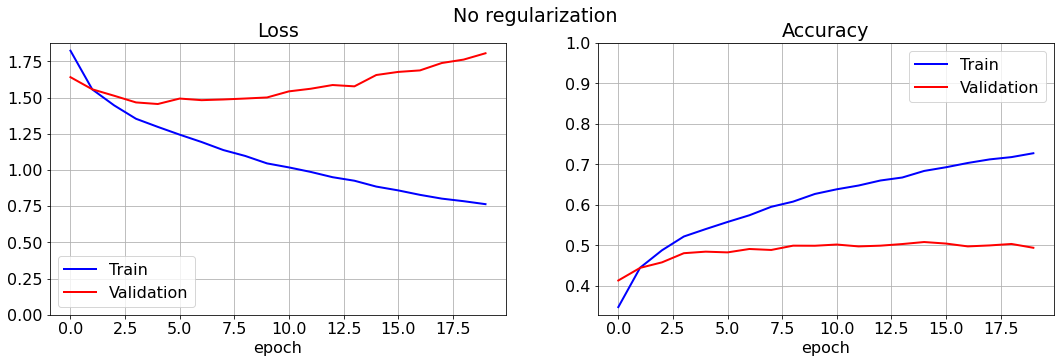

In [14]:
def PlotHistory(lHistory):

    vTrainLoss, vTrainAcc, vValLoss, vValAcc = lHistory
    
    plt.figure(figsize=(18, 5))
    
    plt.subplot(1,2,1)
    plt.plot   (vTrainLoss, 'b', lw=2, label='Train'     )
    plt.plot   (vValLoss,   'r', lw=2, label='Validation')
    plt.title  ('Loss')
    plt.xlabel ('epoch')
    plt.ylim   (bottom=0)
    plt.legend ()
    plt.grid   ()

    plt.subplot(1,2,2)
    plt.plot   (vTrainAcc, 'b', lw=2, label='Train'     )
    plt.plot   (vValAcc,   'r', lw=2, label='Validation')
    plt.title  ('Accuracy')
    plt.xlabel ('epoch')
    plt.ylim   (top=1)
    plt.legend ()
    plt.grid   ()
    
PlotHistory (lHistory)
plt.suptitle('No regularization')
plt.show    ()

### SGDMW - SGDM with weight decay
1. $\boldsymbol{v}^{\left(t\right)}=\beta\boldsymbol{v}^{\left(t-1\right)}-\mu\nabla L\left(\boldsymbol{p}^{\left(t\right)}\right)$
2. $\boldsymbol{p}^{\left(t+1\right)}=\boldsymbol{p}^{\left(t\right)}+\boldsymbol{v}^{\left(t\right)}-\lambda\boldsymbol{p}^{\left(t\right)}$

In [15]:
class SGDMW:
    def __init__(self, lr=1e-3, beta=0.9, wd=0):
        self.lr   = lr
        self.beta = beta
        self.wd   = wd #-- weight decay

    def Step(self, mW, mDw, dState={}):
        mV            = dState.get('mV', np.zeros(mW.shape))
        mV            = self.beta * mV - self.lr * mDw
        mW           += mV - self.wd * mW
        dState['mV']  = mV

        return mW, dState

#### Train with weight decay:

In [16]:
np.random.seed(1)

oModel  = GetModel()
oOptim  = Optimizer(SGDMW(lr=5e-2, beta=0.9, wd=2e-3))
nEpochs = 20

oModel, lHistory = TrainModel(oModel, oTrainSet, oValSet, nEpochs, oOptim)

Epoch 000: | Train loss: 1.80759 | Val loss: 1.62378 | Train Accuracy: 0.3567 | Val Accuracy: 0.4150 | epoch time: 4.392 | <-- Checkpoint!
Epoch 001: | Train loss: 1.53524 | Val loss: 1.51219 | Train Accuracy: 0.4543 | Val Accuracy: 0.4600 | epoch time: 4.276 | <-- Checkpoint!
Epoch 002: | Train loss: 1.43330 | Val loss: 1.49412 | Train Accuracy: 0.4918 | Val Accuracy: 0.4626 | epoch time: 4.721 | <-- Checkpoint!
Epoch 003: | Train loss: 1.36424 | Val loss: 1.44372 | Train Accuracy: 0.5159 | Val Accuracy: 0.4862 | epoch time: 4.432 | <-- Checkpoint!
Epoch 004: | Train loss: 1.31404 | Val loss: 1.42274 | Train Accuracy: 0.5369 | Val Accuracy: 0.4946 | epoch time: 4.448 | <-- Checkpoint!
Epoch 005: | Train loss: 1.28555 | Val loss: 1.43742 | Train Accuracy: 0.5455 | Val Accuracy: 0.4958 | epoch time: 4.149 | <-- Checkpoint!
Epoch 006: | Train loss: 1.25468 | Val loss: 1.39589 | Train Accuracy: 0.5527 | Val Accuracy: 0.4984 | epoch time: 4.220 | <-- Checkpoint!
Epoch 007: | Train loss: 1.

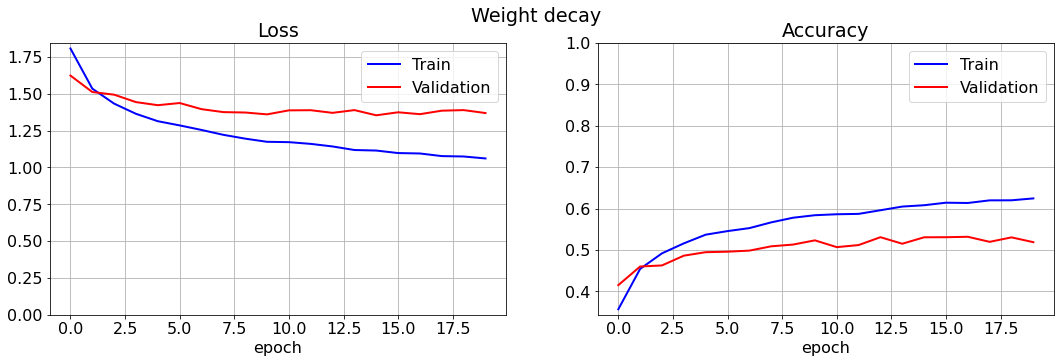

In [17]:
PlotHistory (lHistory)
plt.suptitle('Weight decay')
plt.show    ()

### Dropout layer:
Forwrad:
$$\boldsymbol{z}=\frac{1}{p}\boldsymbol{x}\odot\boldsymbol{m}=\frac{1}{p}\text{diag}\left(\boldsymbol{m}\right)\boldsymbol{x}$$
where $\boldsymbol{m}$ is a mask (same size as $\boldsymbol{x}$)
such that each $\boldsymbol{m}\left[i\right]\sim\text{Bernoulli}\left(p\right)$

Backward:
$$
\left\langle \nabla_{\boldsymbol{z}}L,\nabla_{\boldsymbol{x}}\boldsymbol{z}\left[\boldsymbol{h}\right]\right\rangle =\left\langle \nabla_{\boldsymbol{z}}L,\frac{1}{p}\text{diag}\left(\boldsymbol{m}\right)\boldsymbol{h}\right\rangle =\left\langle \frac{1}{p}\text{diag}\left(\boldsymbol{m}\right)\nabla_{\boldsymbol{z}}L,\boldsymbol{h}\right\rangle 
$$
$$
\implies\boxed{\nabla_{\boldsymbol{x}}L=\frac{1}{p}\text{diag}\left(\boldsymbol{m}\right)\nabla_{\boldsymbol{z}}L=\frac{1}{p}\nabla_{\boldsymbol{z}}L\odot\boldsymbol{m}}
$$
* `Forward` - for train time (with dropout).
* `Predict` - for test  time (without dropout).


In [18]:
class DropoutLayer:
    def __init__(self, p=0.5):
        self.dParams = {}
        self.dGrads  = {}
        self.p       = p

    #-- Train time:
    def Forward(self, mX):
        self.mMask = (np.random.rand(*mX.shape) < self.p) / self.p
        mZ         = mX * self.mMask

        return mZ

    #-- Test time:
    def Predict(self, mX):
        return mX
    
    def Backward(self, mDz):
        mDx   = mDz * self.mMask

        return mDx

###  Update `SequentialModel` class
* `self.train = True`  for train time.
* `self.train = False` for test time.
* `Forward` checks for `self.train`.

In [19]:
class SequentialModel:
    def __init__(self, lLayers):
        self.lLayers = lLayers
        #======================#
        self.train   = False
        #======================#

    def Forward(self, mX):
        for oLayer in self.lLayers:
            #====================================================#
            if self.train == False and hasattr(oLayer, 'Predict'):
                mX = oLayer.Predict(mX) #-- test time
            else:
                mX = oLayer.Forward(mX) #-- train time
            #====================================================#
        return mX

    def Backward(self, mDz):
        for oLayer in reversed(self.lLayers):
            mDz = oLayer.Backward(mDz)

#### Set `oModel.train` before `Epoch`:

In [20]:
import time
import _pickle as pickle

def TrainModel(oModel, oTrainData, oValData, nEpochs, oOptim):

    vTrainLoss = np.full(nEpochs, np.nan)
    vTrainAcc  = np.full(nEpochs, np.nan)
    vValLoss   = np.full(nEpochs, np.nan)
    vValAcc    = np.full(nEpochs, np.nan)
    bestAcc    = 0
        
    for epoch in range(nEpochs):
        startTime = time.time()
        #===================================================================#
        oModel.train        = True 
        trainLoss, trainAcc = Epoch(oModel, oTrainData, oOptim, bTrain=True )
        #===================================================================#
        #===================================================================#
        oModel.train        = False
        valLoss,   valAcc   = Epoch(oModel, oValData,           bTrain=False)
        #===================================================================#
        epochTime = time.time() - startTime

        #-- Display:
        print('Epoch '              f'{epoch    :03d}:',   end='')
        print(' | Train loss: '     f'{trainLoss:.5f}' ,   end='')
        print(' | Val loss: '       f'{valLoss  :.5f}' ,   end='')
        print(' | Train Accuracy: ' f'{trainAcc :2.4f}',   end='')
        print(' | Val Accuracy: '   f'{valAcc   :2.4f}',   end='')
        print(' | epoch time: '     f'{epochTime:3.3f} |', end='')

        vTrainLoss[epoch] = trainLoss
        vTrainAcc [epoch] = trainAcc
        vValLoss  [epoch] = valLoss
        vValAcc   [epoch] = valAcc
        
        #-- Save best model (early stopping):
        if valAcc > bestAcc:
            bestAcc = valAcc
            print(' <-- Checkpoint!', end='')
            with open('BestModel.pkl', 'wb') as oFile:
                pickle.dump(oModel, oFile)
        print('')
                
    #-- Load best model (early stopping):
    with open('BestModel.pkl', 'rb') as oFile:
        oModel = pickle.load(oFile)
                
    return oModel, (vTrainLoss, vTrainAcc, vValLoss, vValAcc)

### Model with dropouts:

In [21]:
def GetModelWithDropout(dropout=0.5):
    dIn = 32 * 32 * 3
    
    oModel = SequentialModel([
        LinearLayer(dIn, 200), ReLULayer(), DropoutLayer(dropout),
        LinearLayer(200, 100), ReLULayer(), DropoutLayer(dropout),
        LinearLayer(100, 50 ), ReLULayer(), DropoutLayer(dropout),
        LinearLayer(50,  10 ),
    ])
    
    return oModel

#### Train with dropout:

In [22]:
np.random.seed(1)

oModel  = GetModelWithDropout(0.8)
oOptim  = Optimizer(SGDM(lr=5e-2, beta=0.9))
nEpochs = 20

oModel, lHistory = TrainModel(oModel, oTrainSet, oValSet, nEpochs, oOptim)

Epoch 000: | Train loss: 2.04784 | Val loss: 1.78173 | Train Accuracy: 0.2627 | Val Accuracy: 0.3582 | epoch time: 4.097 | <-- Checkpoint!
Epoch 001: | Train loss: 1.81449 | Val loss: 1.64032 | Train Accuracy: 0.3408 | Val Accuracy: 0.4224 | epoch time: 4.469 | <-- Checkpoint!
Epoch 002: | Train loss: 1.71933 | Val loss: 1.59854 | Train Accuracy: 0.3826 | Val Accuracy: 0.4224 | epoch time: 4.607 |
Epoch 003: | Train loss: 1.66725 | Val loss: 1.56760 | Train Accuracy: 0.4022 | Val Accuracy: 0.4446 | epoch time: 4.528 | <-- Checkpoint!
Epoch 004: | Train loss: 1.62415 | Val loss: 1.52258 | Train Accuracy: 0.4221 | Val Accuracy: 0.4490 | epoch time: 4.424 | <-- Checkpoint!
Epoch 005: | Train loss: 1.57851 | Val loss: 1.51343 | Train Accuracy: 0.4380 | Val Accuracy: 0.4470 | epoch time: 4.358 |
Epoch 006: | Train loss: 1.55499 | Val loss: 1.49596 | Train Accuracy: 0.4453 | Val Accuracy: 0.4628 | epoch time: 4.316 | <-- Checkpoint!
Epoch 007: | Train loss: 1.52061 | Val loss: 1.44966 | Trai

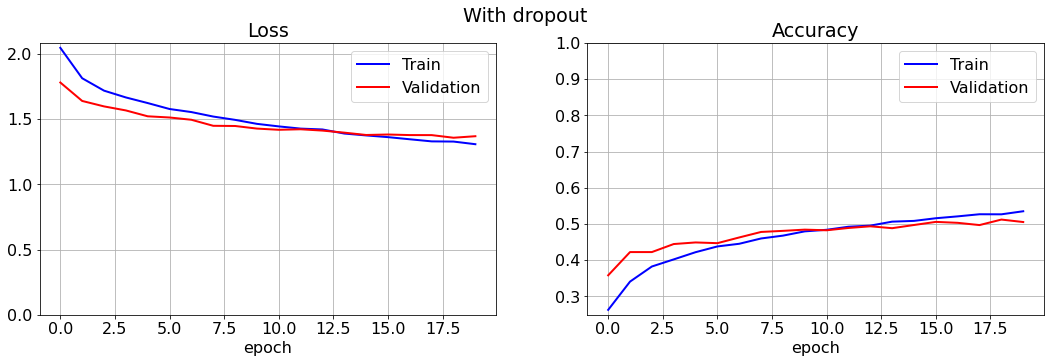

In [23]:
PlotHistory (lHistory)
plt.suptitle('With dropout')
plt.show    ()

### Dropout + weight decay:

In [24]:
np.random.seed(1)

oModel  = GetModelWithDropout(0.9)
oOptim  = Optimizer(SGDMW(lr=5e-2, beta=0.9, wd=1e-3))
nEpochs = 20

oModel, lHistory = TrainModel(oModel, oTrainSet, oValSet, nEpochs, oOptim)

Epoch 000: | Train loss: 1.92277 | Val loss: 1.67445 | Train Accuracy: 0.3112 | Val Accuracy: 0.4008 | epoch time: 4.648 | <-- Checkpoint!
Epoch 001: | Train loss: 1.67572 | Val loss: 1.54913 | Train Accuracy: 0.4010 | Val Accuracy: 0.4454 | epoch time: 4.732 | <-- Checkpoint!
Epoch 002: | Train loss: 1.57439 | Val loss: 1.51495 | Train Accuracy: 0.4405 | Val Accuracy: 0.4562 | epoch time: 4.939 | <-- Checkpoint!
Epoch 003: | Train loss: 1.51315 | Val loss: 1.45680 | Train Accuracy: 0.4642 | Val Accuracy: 0.4834 | epoch time: 4.845 | <-- Checkpoint!
Epoch 004: | Train loss: 1.46353 | Val loss: 1.43049 | Train Accuracy: 0.4825 | Val Accuracy: 0.4954 | epoch time: 4.896 | <-- Checkpoint!
Epoch 005: | Train loss: 1.42538 | Val loss: 1.43402 | Train Accuracy: 0.4950 | Val Accuracy: 0.4924 | epoch time: 4.883 |
Epoch 006: | Train loss: 1.38443 | Val loss: 1.39613 | Train Accuracy: 0.5079 | Val Accuracy: 0.4974 | epoch time: 4.834 | <-- Checkpoint!
Epoch 007: | Train loss: 1.35177 | Val loss

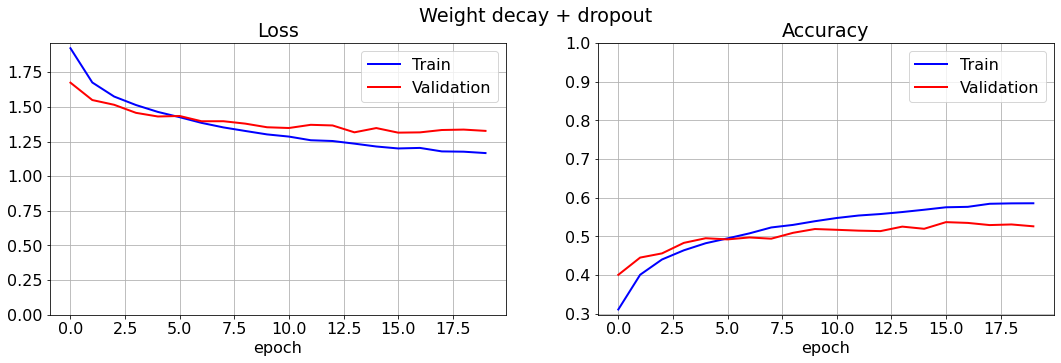

In [25]:
PlotHistory (lHistory)
plt.suptitle('Weight decay + dropout')
plt.show    ()